**4. Implementation and Experimental Setup**

This section details the full implementation process, from data preprocessing to model training and evaluation. The objective is to compare traditional machine learning models (Logistic Regression, Decision Tree, Random Forest) with time-series-based models (LSTM) to assess the impact of sequential interaction data on lead conversion predictions.

**4.1 Data Processing Pipeline**

A structured data processing pipeline ensures that the dataset is clean, balanced, and ready for model training. The following steps outline the data preparation process.

**Step 1: Load the Dataset and Inspect Data**

The dataset is loaded from an Excel file containing Static Features and Dynamic Features sheets, followed by an initial exploratory analysis to understand its structure, missing values, and key variables.

In [1]:
import pandas as pd

# Define file path (update this if necessary)
file_path = r"C:\Users\user\Desktop\lead_Scores.xlsx"

# Load both sheets
static_df = pd.read_excel(file_path, sheet_name="Static Features")
dynamic_df = pd.read_excel(file_path, sheet_name="Dynamic Features")

# Display first few rows of each dataset
print("\n Static Features Dataset (First 5 Rows):")
print(static_df.head())

print("\n Dynamic Features Dataset (First 5 Rows):")
print(dynamic_df.head())

# Check basic info
print("\n Static Features Info:")
print(static_df.info())

print("\n Dynamic Features Info:")
print(dynamic_df.info())

# Check for missing values
print("\n Missing Values in Static Features:")
print(static_df.isnull().sum())

print("\n Missing Values in Dynamic Features:")
print(dynamic_df.isnull().sum())

# Check unique Lead Numbers
print("\n Unique Lead Numbers Count:")
print(f"Static Features: {static_df['Lead Number'].nunique()} leads")
print(f"Dynamic Features: {dynamic_df['Lead Number'].nunique()} leads")


 Static Features Dataset (First 5 Rows):
   Lead Number              Lead Origin     Lead Source  Converted  \
0       579533  Landing Page Submission  Direct Traffic          1   
1       579538  Landing Page Submission          Google          1   
2       579545  Landing Page Submission  Direct Traffic          0   
3       579546  Landing Page Submission  Direct Traffic          0   
4       579564  Landing Page Submission  Direct Traffic          1   

   TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
0          6.0                         1279                  3.00   
1          3.0                          499                  3.00   
2          2.0                          199                  2.00   
3          2.0                          238                  2.00   
4          8.0                         1845                  2.67   

       Last Activity What is your current occupation  \
0           SMS Sent                      Unemployed   
1         

**Step 2: Exploratory Data Analysis (EDA)**

This section provides an in-depth analysis of the dataset to uncover patterns, distributions, and relationships between features and the target variable (Converted). Various visualizations, including histograms, bar plots, boxplots, violin plots, and correlation heatmaps, are used to assess feature importance, detect potential biases, and guide data preprocessing decisions for model training.

**Distribution of Numeric Columns**

Histograms were plotted to visualize the spread and skewness of numerical features.

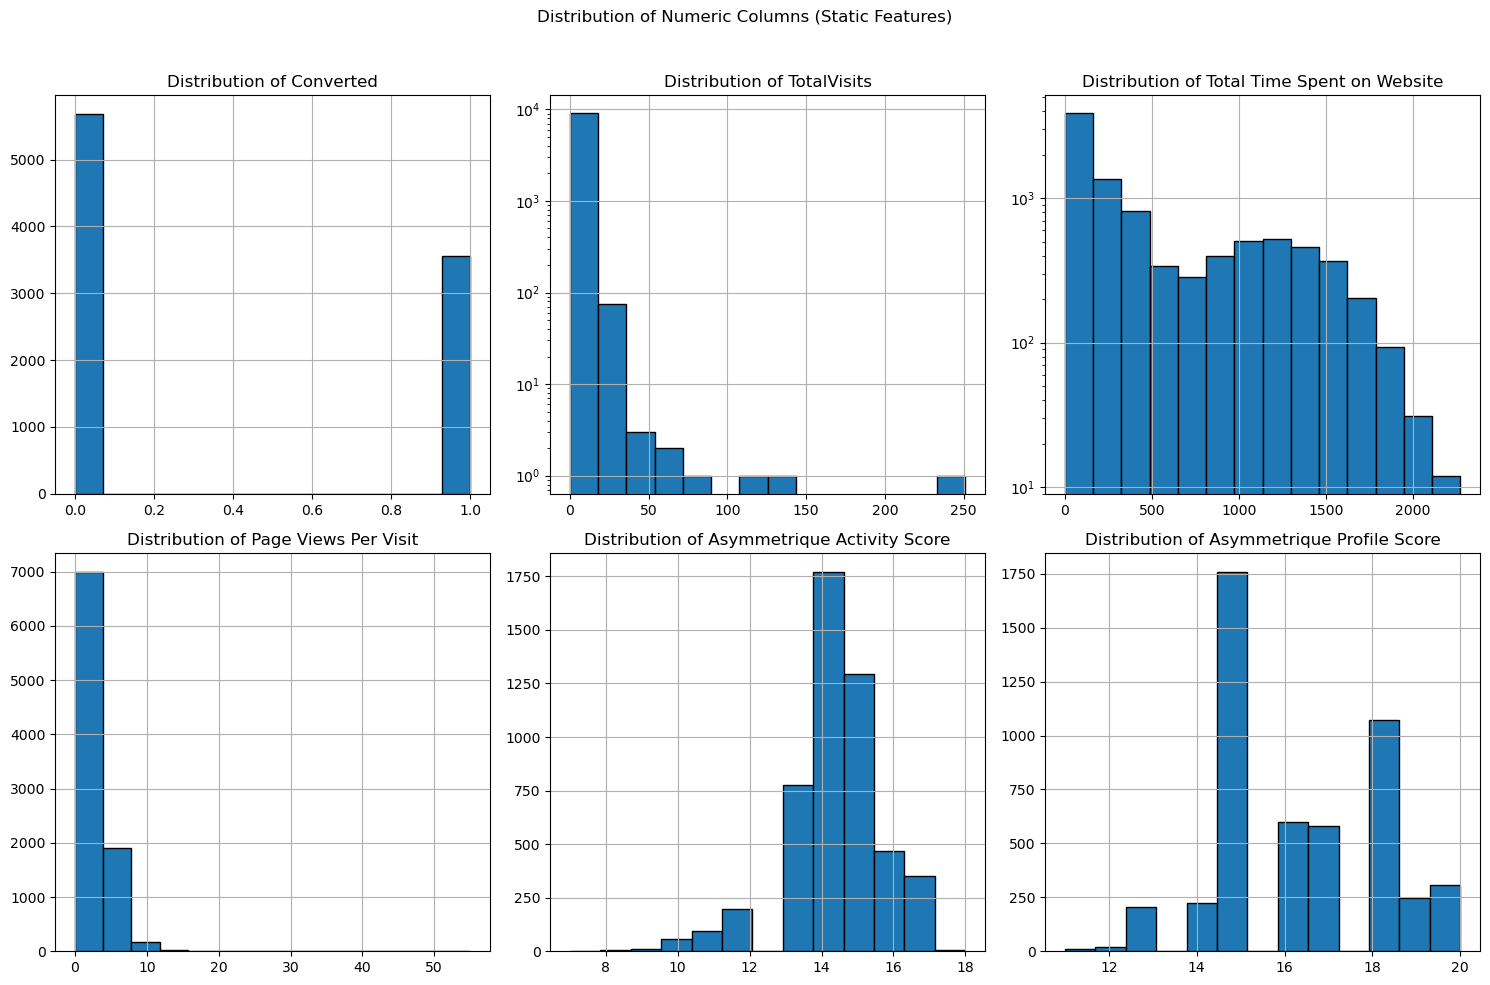

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

# Assuming static_df is your DataFrame
# First, define numeric_cols
numeric_cols = static_df.select_dtypes(include=[np.number]).columns.tolist()

# Exclude 'Lead Number' from numeric features
numeric_cols = [col for col in numeric_cols if col != "Lead Number"]

# Determine layout dynamically
num_features = len(numeric_cols)
cols = 3  # Set number of columns for subplots
rows = math.ceil(num_features / cols)  # Determine rows dynamically

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()  # Flatten in case of a single row

for i, col in enumerate(numeric_cols):
    # Dynamically determine bin size using Sturges' Rule
    bins = int(1 + np.log2(static_df[col].count()))
    
    static_df[col].hist(bins=bins, edgecolor='black', ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    
    # Log scale for highly skewed distributions (optional)
    if static_df[col].max() > 100:
        axes[i].set_yscale("log")

# Remove extra subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distribution of Numeric Columns (Static Features)")
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout
plt.show()


**Distribution of Categorical Columns**

Bar charts were used to analyze the frequency distribution of categorical variables.

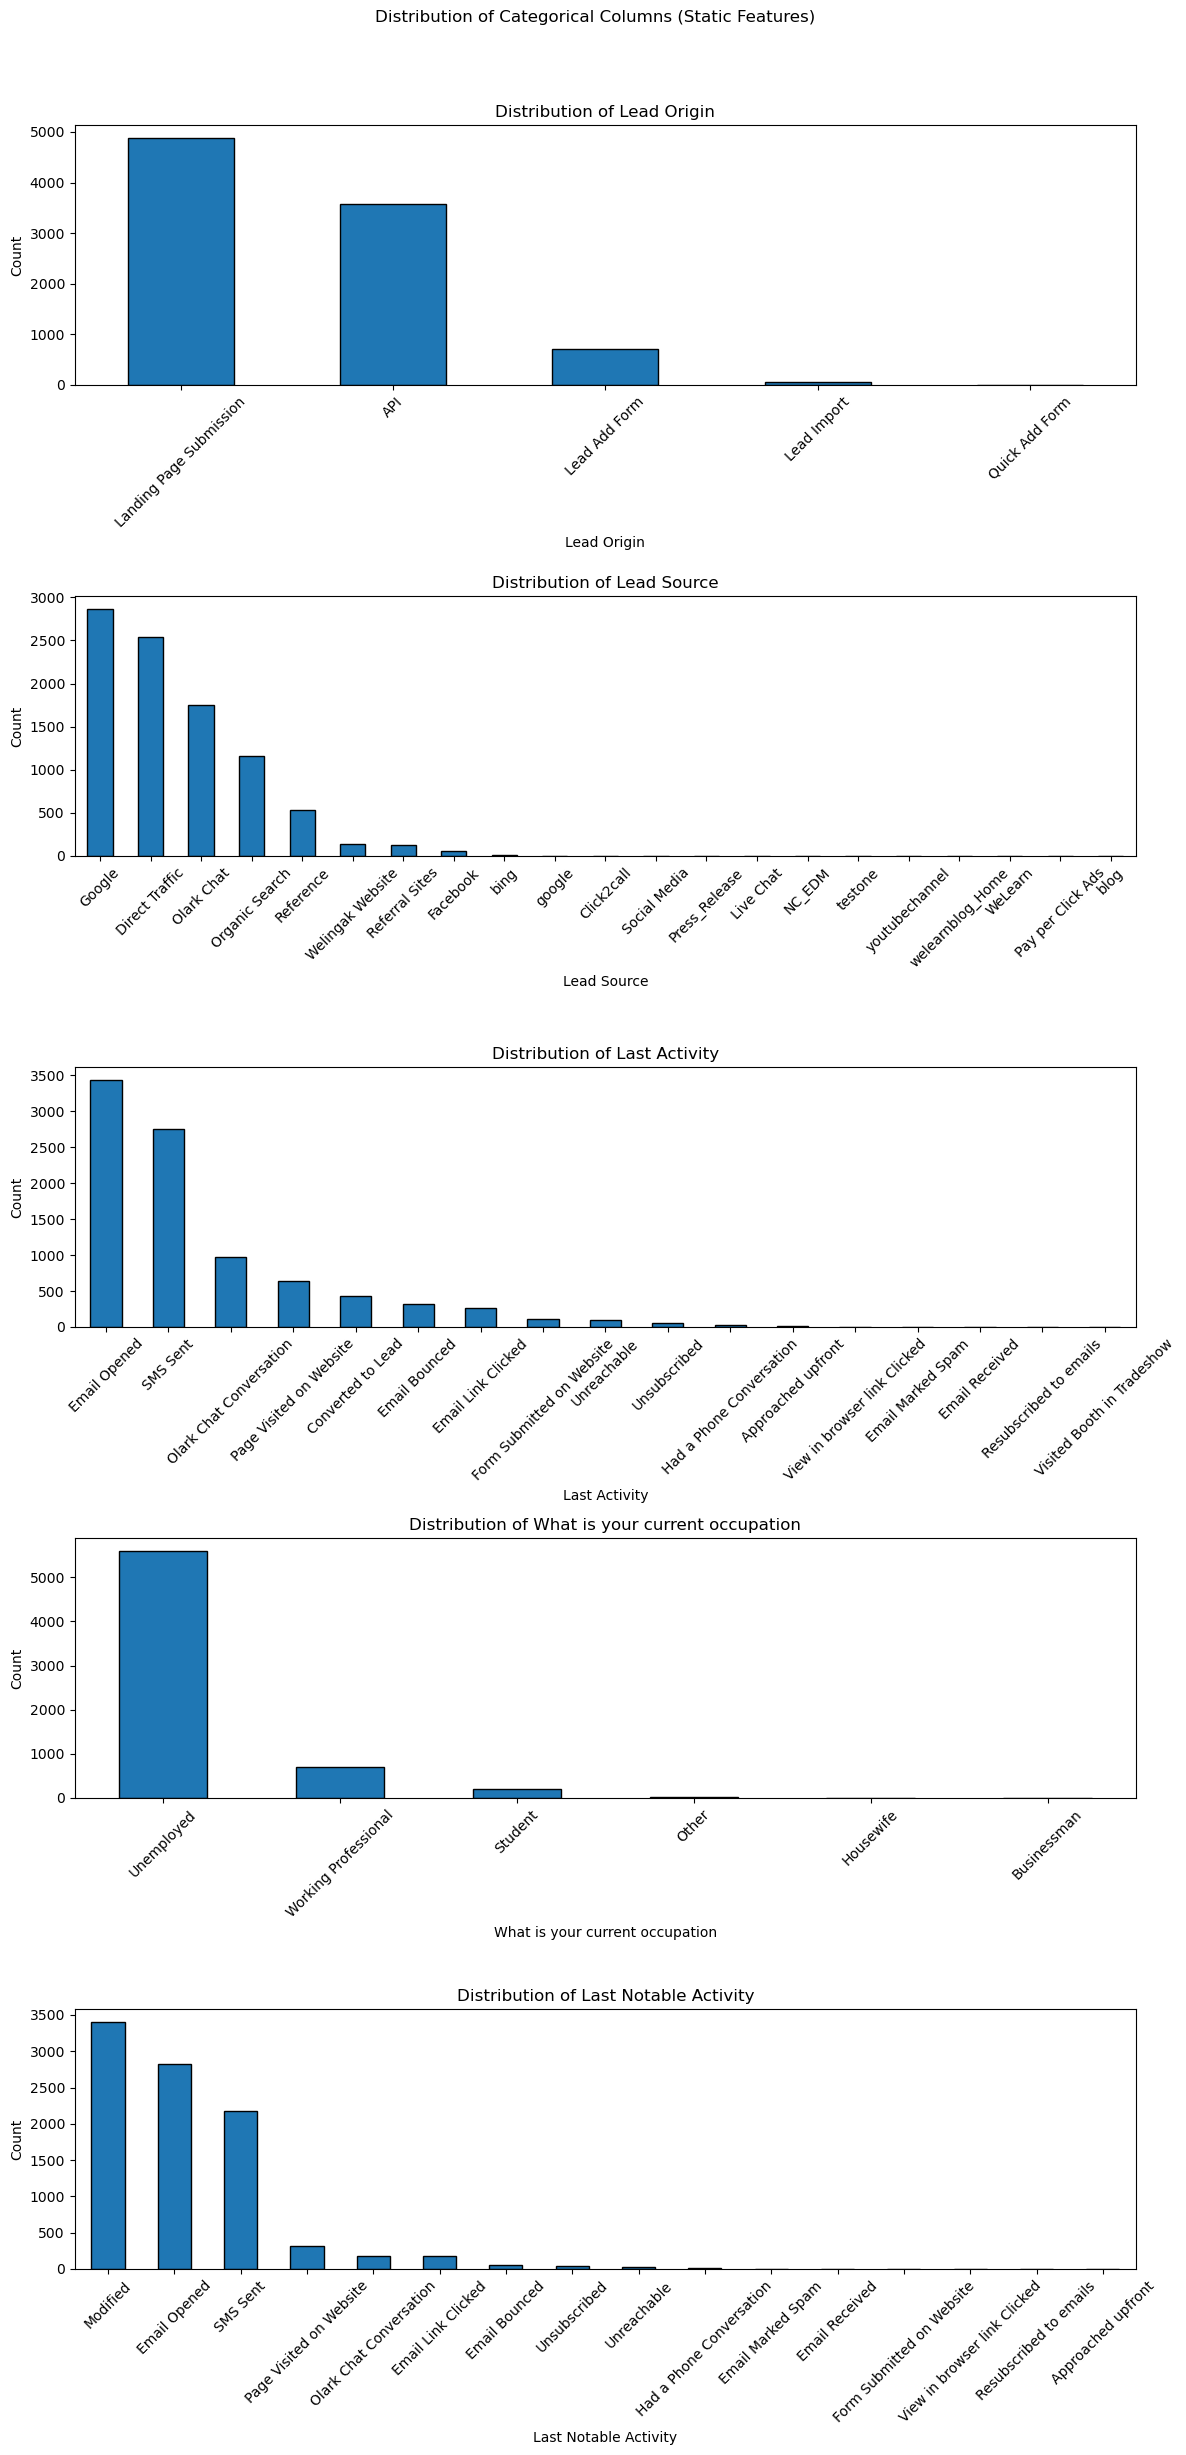

In [3]:
categorical_cols = static_df.select_dtypes(include=['object']).columns

# Plot categorical distributions
fig, axes = plt.subplots(len(categorical_cols), 1, figsize=(12, 5 * len(categorical_cols)))

for i, col in enumerate(categorical_cols):
    static_df[col].value_counts().plot(kind='bar', ax=axes[i], edgecolor="black")
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=45)

plt.suptitle("Distribution of Categorical Columns (Static Features)")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


**Investigating Relationship Between Target Variable and Numeric Features**

Boxplots and violin plots were generated to explore how numerical features impact lead conversion.

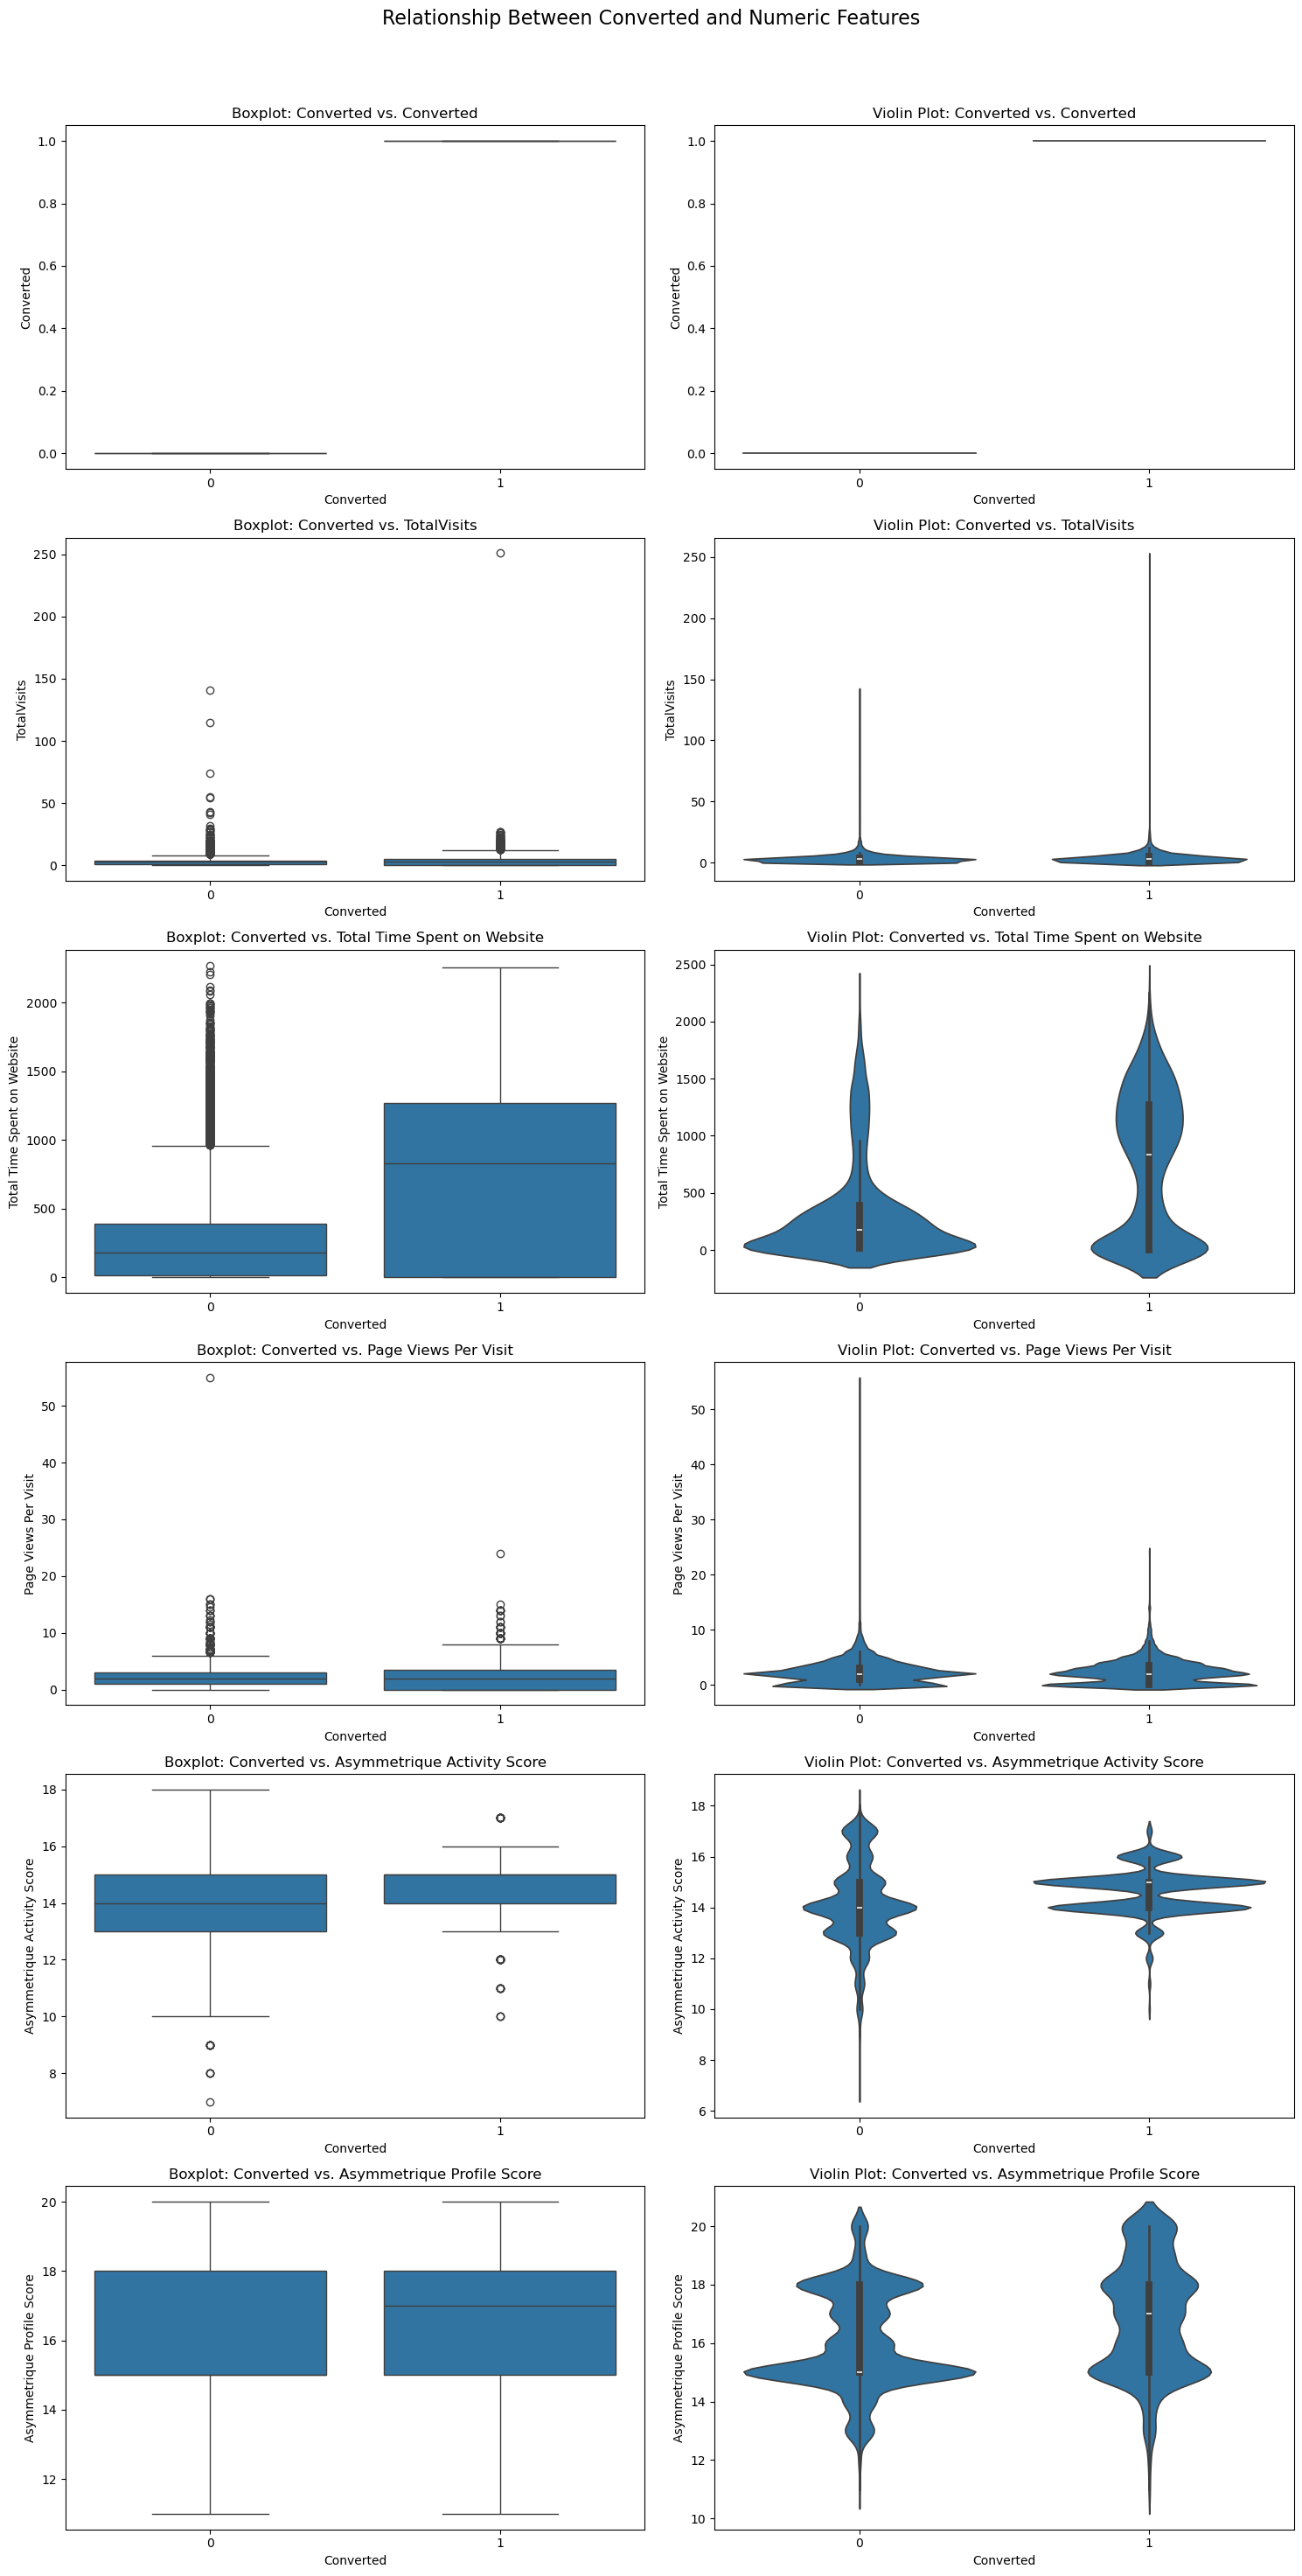

In [4]:
import seaborn as sns

# Define numeric features excluding Lead Number
numeric_cols = [col for col in static_df.select_dtypes(include=['number']).columns if col not in ["Lead Number"]]

# Create subplots
fig, axes = plt.subplots(len(numeric_cols), 2, figsize=(15, 5 * len(numeric_cols)))

for i, col in enumerate(numeric_cols):
    # Boxplot
    sns.boxplot(x=static_df["Converted"], y=static_df[col], ax=axes[i, 0])
    axes[i, 0].set_title(f"Boxplot: Converted vs. {col}")
    
    # Violin plot
    sns.violinplot(x=static_df["Converted"], y=static_df[col], ax=axes[i, 1])
    axes[i, 1].set_title(f"Violin Plot: Converted vs. {col}")

plt.suptitle("Relationship Between Converted and Numeric Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


**Relationship Between Target Variable and Categorical Features**

Grouped bar plots were used to examine conversion rates across different categorical feature categories.

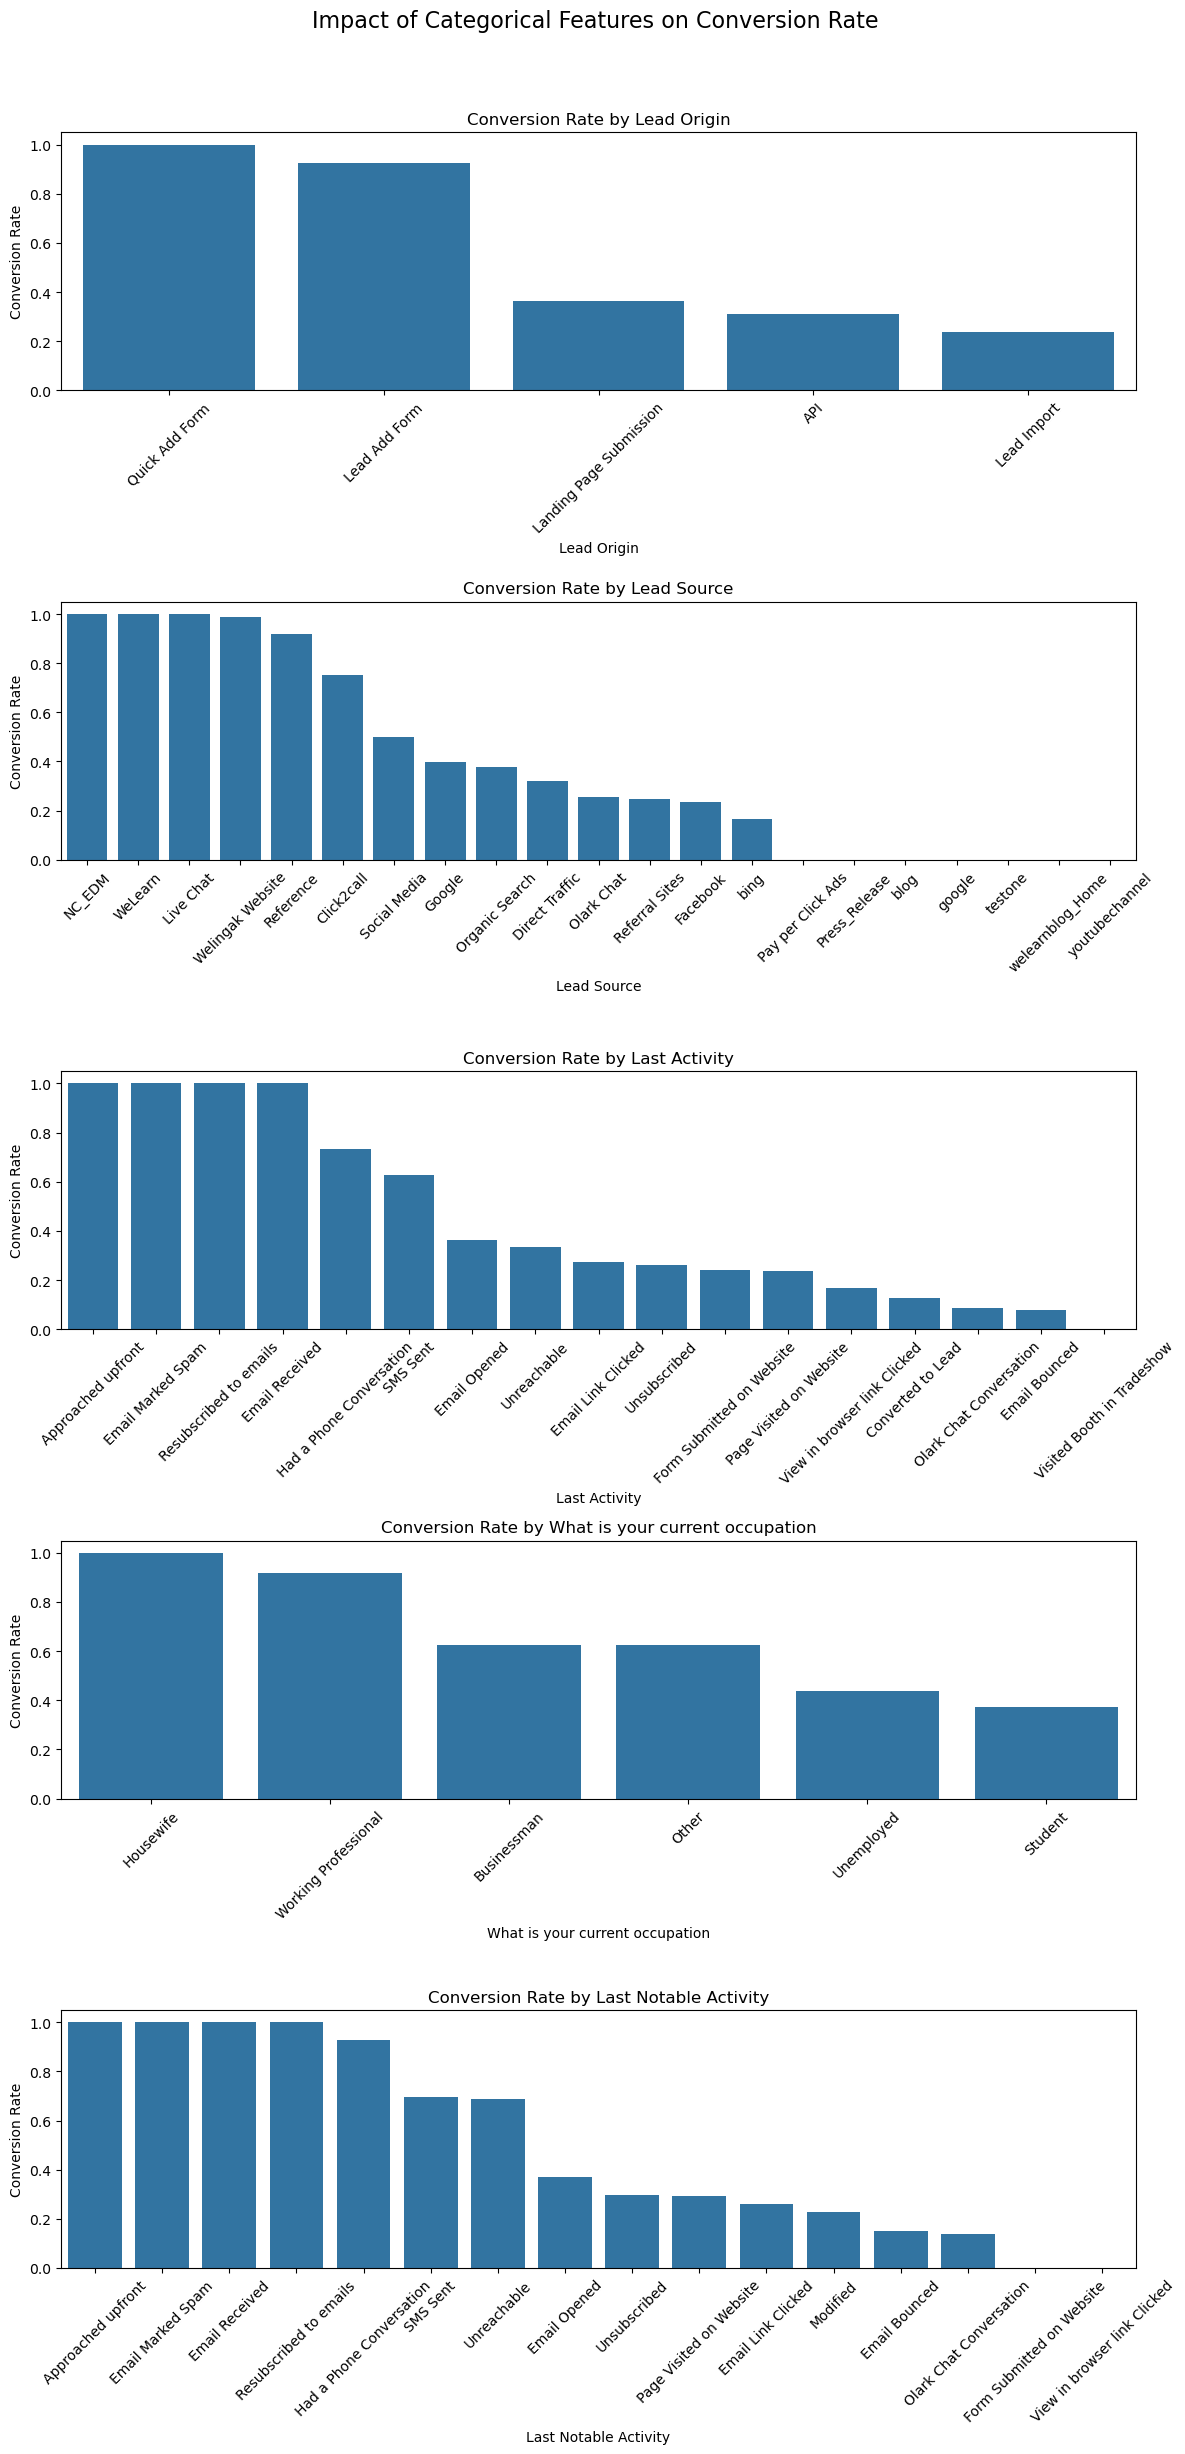

In [5]:
import seaborn as sns

categorical_cols = static_df.select_dtypes(include=['object']).columns

# Create subplots
fig, axes = plt.subplots(len(categorical_cols), 1, figsize=(12, 5 * len(categorical_cols)))

for i, col in enumerate(categorical_cols):
    # Plot conversion rate per category
    conversion_rates = static_df.groupby(col)["Converted"].mean().sort_values(ascending=False)
    sns.barplot(x=conversion_rates.index, y=conversion_rates.values, ax=axes[i])
    axes[i].set_title(f"Conversion Rate by {col}")
    axes[i].set_ylabel("Conversion Rate")
    axes[i].tick_params(axis='x', rotation=45)

plt.suptitle("Impact of Categorical Features on Conversion Rate", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


**Correlation Matrix**

A heatmap was created to identify the strength of relationships between numerical variables, highlighting key predictors of lead conversion.

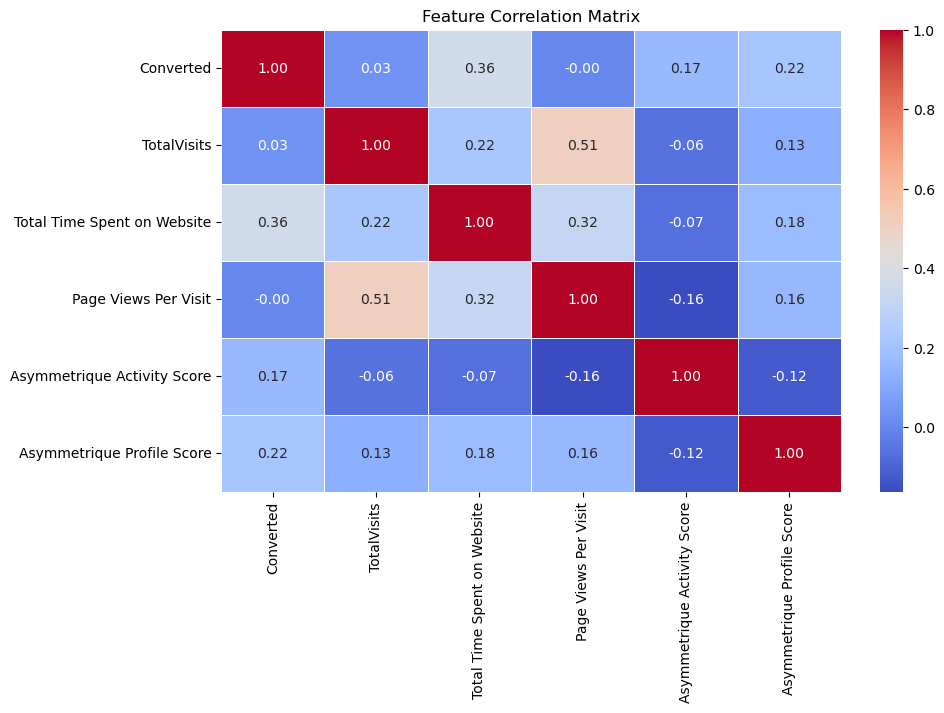

In [6]:
import numpy as np

# Select only numeric columns and exclude 'Lead Number'
numeric_df = static_df.select_dtypes(include=[np.number]).drop(columns=["Lead Number"], errors='ignore')

# Compute correlation matrix
plt.figure(figsize=(10, 6))
correlation_matrix = numeric_df.corr()

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()




**Step 3: Handling Missing Data and Feature Selection**

Missing values in categorical and numerical features are addressed through imputation techniques, ensuring that the dataset remains complete without introducing bias or data leakage.

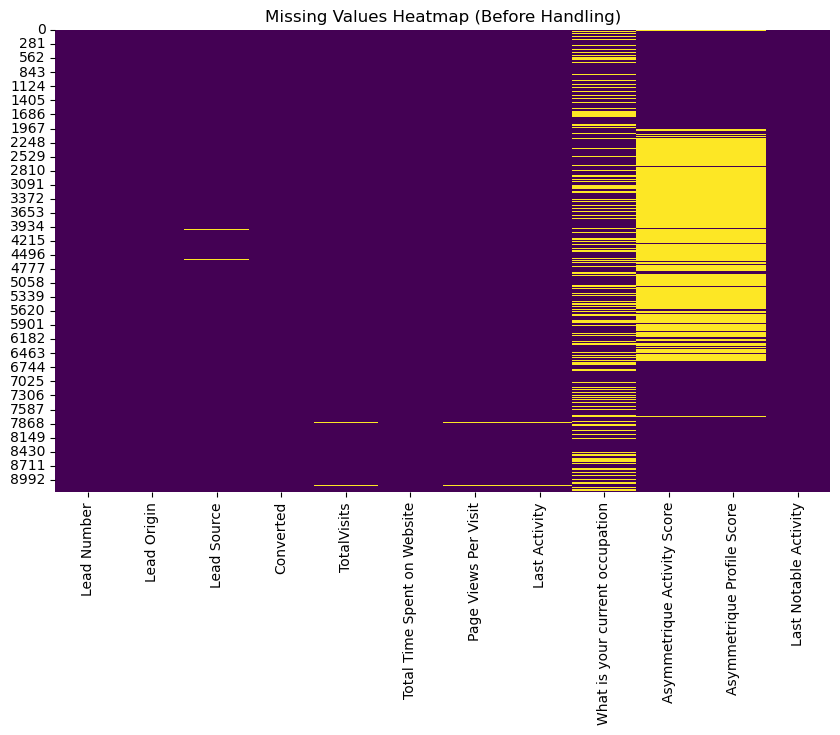

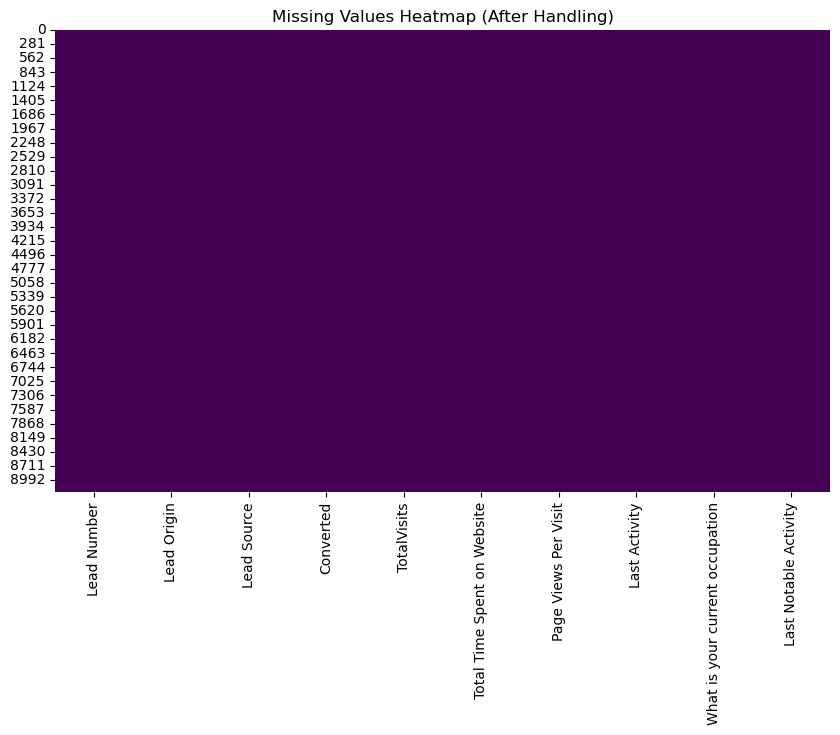


 Missing values after handling (Static Features):
Series([], dtype: int64)

 Missing values after handling (Dynamic Features):
Series([], dtype: int64)

 Fixed Data Types in Dynamic Dataset:
Lead Number                                   int64
Interaction Timestamp                datetime64[ns]
Type of Interaction                          object
Interaction Outcome                          object
Cumulative Interaction Count                  int64
Time Between Interactions (hours)           float64
Peak Interaction Time                        object
dtype: object

 Updated Static Dataset Columns:
Index(['Lead Number', 'Lead Origin', 'Lead Source', 'Converted', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity',
       'What is your current occupation', 'Last Notable Activity'],
      dtype='object')


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Handling Missing Data and Feature Selection

# Visualizing Missing Data Before Handling
plt.figure(figsize=(10, 6))
sns.heatmap(static_df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap (Before Handling)")
plt.show()

# Identify categorical and numerical columns separately
categorical_cols = static_df.select_dtypes(include=["object"]).columns
numerical_cols = static_df.select_dtypes(include=["number"]).columns

# Fill categorical variables with mode (most frequent value)
static_df[categorical_cols] = static_df[categorical_cols].apply(lambda col: col.fillna(col.mode()[0]))

# Fill numerical variables with median
static_df[numerical_cols] = static_df[numerical_cols].apply(lambda col: col.fillna(col.median()))

# Define columns to drop (if they exist)
columns_to_drop = ["Asymmetrique Activity Index", "Asymmetrique Profile Index", 
                   "Asymmetrique Activity Score", "Asymmetrique Profile Score", 
                   "Lead Quality", "Tags"]

# Drop only the columns that exist in the dataset
existing_columns_to_drop = [col for col in columns_to_drop if col in static_df.columns]
if existing_columns_to_drop:
    static_df.drop(columns=existing_columns_to_drop, inplace=True)

# Fix Data Type Issue in Dynamic Dataset (Time Between Interactions)
dynamic_df["Time Between Interactions (hours)"] = (
    dynamic_df["Time Between Interactions (hours)"]
    .astype(str)  # Ensure all are strings before extraction
    .str.extract(r"([\d.]+)")  # Extract numeric values only
    .astype(float)  # Convert to float
)

# Visualizing Missing Data After Handling
plt.figure(figsize=(10, 6))
sns.heatmap(static_df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap (After Handling)")
plt.show()

# Confirm no missing values remain
print("\n Missing values after handling (Static Features):")
print(static_df.isnull().sum()[static_df.isnull().sum() > 0])

print("\n Missing values after handling (Dynamic Features):")
print(dynamic_df.isnull().sum()[dynamic_df.isnull().sum() > 0])

# Check data type fixes
print("\n Fixed Data Types in Dynamic Dataset:")
print(dynamic_df.dtypes)

# Check updated static dataset structure
print("\n Updated Static Dataset Columns:")
print(static_df.columns)

**Step 4: Identify and Encoding Categorical Variables**

Categorical features are transformed into numerical representations using One-Hot Encoding (OHE) for nominal data and Label Encoding for ordinal data, making them suitable for model training.

In [8]:
# Identify categorical columns in both datasets
categorical_static = static_df.select_dtypes(include=["object"]).columns.tolist()
categorical_dynamic = dynamic_df.select_dtypes(include=["object"]).columns.tolist()

print("\n Categorical Variables in Static Features:")
print(categorical_static)

print("\n Categorical Variables in Dynamic Features:")
print(categorical_dynamic)


 Categorical Variables in Static Features:
['Lead Origin', 'Lead Source', 'Last Activity', 'What is your current occupation', 'Last Notable Activity']

 Categorical Variables in Dynamic Features:
['Type of Interaction', 'Interaction Outcome', 'Peak Interaction Time']


In [9]:
from sklearn.preprocessing import OneHotEncoder

# Identify categorical columns in both datasets
categorical_cols_static = ["Lead Origin", "Lead Source", "Last Activity", "What is your current occupation", "Last Notable Activity"]
categorical_cols_dynamic = ["Type of Interaction", "Interaction Outcome", "Peak Interaction Time"]

# One-Hot Encoding for static dataset
encoder_static = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
encoded_static = encoder_static.fit_transform(static_df[categorical_cols_static])

# Convert to DataFrame
encoded_static_df = pd.DataFrame(encoded_static, columns=encoder_static.get_feature_names_out(categorical_cols_static))

# Merge with original dataset (drop old categorical columns)
static_df = pd.concat([static_df.drop(columns=categorical_cols_static), encoded_static_df], axis=1)

# One-Hot Encoding for dynamic dataset
encoder_dynamic = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
encoded_dynamic = encoder_dynamic.fit_transform(dynamic_df[categorical_cols_dynamic])

# Convert to DataFrame
encoded_dynamic_df = pd.DataFrame(encoded_dynamic, columns=encoder_dynamic.get_feature_names_out(categorical_cols_dynamic))

# Merge with original dataset (drop old categorical columns)
dynamic_df = pd.concat([dynamic_df.drop(columns=categorical_cols_dynamic), encoded_dynamic_df], axis=1)

# Confirm encoding success
print("\n First 5 Rows of Static Features After Encoding:")
print(static_df.head())

print("\n First 5 Rows of Dynamic Features After Encoding:")
print(dynamic_df.head())

print("\n Updated Static Dataset Shape:", static_df.shape)
print("\n Updated Dynamic Dataset Shape:", dynamic_df.shape)



 First 5 Rows of Static Features After Encoding:
   Lead Number  Converted  TotalVisits  Total Time Spent on Website  \
0       579533          1          6.0                         1279   
1       579538          1          3.0                          499   
2       579545          0          2.0                          199   
3       579546          0          2.0                          238   
4       579564          1          8.0                         1845   

   Page Views Per Visit  Lead Origin_API  Lead Origin_Landing Page Submission  \
0                  3.00              0.0                                  1.0   
1                  3.00              0.0                                  1.0   
2                  2.00              0.0                                  1.0   
3                  2.00              0.0                                  1.0   
4                  2.67              0.0                                  1.0   

   Lead Origin_Lead Add Form  Lead O

**Step 5: Feature Engineering**

Additional features are derived to enhance model performance, including aggregating dynamic interaction counts, calculating time differences between interactions, and extracting behavioral patterns from historical data.

In [10]:
# Ensure Interaction Timestamp is in datetime format
dynamic_df["Interaction Timestamp"] = pd.to_datetime(dynamic_df["Interaction Timestamp"])

# Convert Interaction Timestamp to Numeric Format (Days Since First Interaction)
dynamic_df["Days Since First Interaction"] = (dynamic_df["Interaction Timestamp"] - dynamic_df["Interaction Timestamp"].min()).dt.days

# Feature Engineering: Creating Interaction Frequency per Lead
interaction_counts = dynamic_df.groupby("Lead Number")["Cumulative Interaction Count"].max().reset_index()

# Ensure the correct column name before renaming
print("\n Columns in interaction_counts before renaming:", interaction_counts.columns)

# Rename for clarity
interaction_counts.rename(columns={"Cumulative Interaction Count": "Total Interactions"}, inplace=True)

# Ensure the correct column name before merging
print("\n Columns in interaction_counts after renaming:", interaction_counts.columns)

# Merge interaction counts with Static Dataset
static_df = static_df.merge(interaction_counts, on="Lead Number", how="left")

# Check if the column exists after merging
if "Total Interactions" not in static_df.columns:
    raise KeyError("Column 'Total Interactions' is missing after merge!")

# Fix FutureWarning: Assigning the result back correctly
static_df["Total Interactions"] = static_df["Total Interactions"].fillna(0)

# Confirm feature engineering success
print("\n First 5 Rows After Feature Engineering (Static Features):")
print(static_df.head())

print("\n Updated Static Dataset Shape:", static_df.shape)




 Columns in interaction_counts before renaming: Index(['Lead Number', 'Cumulative Interaction Count'], dtype='object')

 Columns in interaction_counts after renaming: Index(['Lead Number', 'Total Interactions'], dtype='object')

 First 5 Rows After Feature Engineering (Static Features):
   Lead Number  Converted  TotalVisits  Total Time Spent on Website  \
0       579533          1          6.0                         1279   
1       579538          1          3.0                          499   
2       579545          0          2.0                          199   
3       579546          0          2.0                          238   
4       579564          1          8.0                         1845   

   Page Views Per Visit  Lead Origin_API  Lead Origin_Landing Page Submission  \
0                  3.00              0.0                                  1.0   
1                  3.00              0.0                                  1.0   
2                  2.00              0.0 

In [11]:
# Drop duplicate 'Total Interactions' columns if they exist
static_df = static_df.drop(columns=["Total Interactions_x", "Total Interactions_y"], errors="ignore")

# Confirm successful cleanup
print("\n Final Static Features After Cleanup:")
print(static_df.head())

print("\n Final Static Dataset Shape:", static_df.shape)



 Final Static Features After Cleanup:
   Lead Number  Converted  TotalVisits  Total Time Spent on Website  \
0       579533          1          6.0                         1279   
1       579538          1          3.0                          499   
2       579545          0          2.0                          199   
3       579546          0          2.0                          238   
4       579564          1          8.0                         1845   

   Page Views Per Visit  Lead Origin_API  Lead Origin_Landing Page Submission  \
0                  3.00              0.0                                  1.0   
1                  3.00              0.0                                  1.0   
2                  2.00              0.0                                  1.0   
3                  2.00              0.0                                  1.0   
4                  2.67              0.0                                  1.0   

   Lead Origin_Lead Add Form  Lead Origin_Lead 

**Step 6: Check Class Distribution**

To mitigate bias in model predictions, SMOTE (Synthetic Minority Oversampling Technique) is applied to balance the class distribution of converted and non-converted leads where neccessary.


 Class Distribution Before Balancing:
Converted
0    5679
1    3561
Name: count, dtype: int64

 Class Percentage Before Balancing:
Converted
0    61.461039
1    38.538961
Name: proportion, dtype: float64


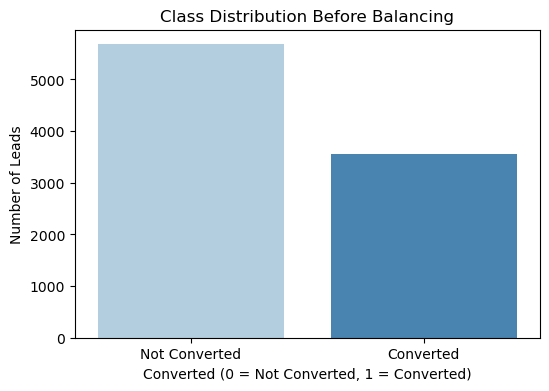

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check class distribution before applying SMOTE
class_counts = static_df['Converted'].value_counts()
class_percentages = static_df['Converted'].value_counts(normalize=True) * 100

print("\n Class Distribution Before Balancing:")
print(class_counts)

print("\n Class Percentage Before Balancing:")
print(class_percentages)

# Plot Class Distribution (Fixed Warning)
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, hue=class_counts.index, palette="Blues", legend=False)

plt.xlabel("Converted (0 = Not Converted, 1 = Converted)")
plt.ylabel("Number of Leads")
plt.title("Class Distribution Before Balancing")
plt.xticks([0, 1], ["Not Converted", "Converted"])
plt.show()





 Class Distribution After SMOTE:
Converted
1    5679
0    5679
Name: count, dtype: int64

 New Class Percentage After SMOTE:
Converted
1    50.0
0    50.0
Name: proportion, dtype: float64


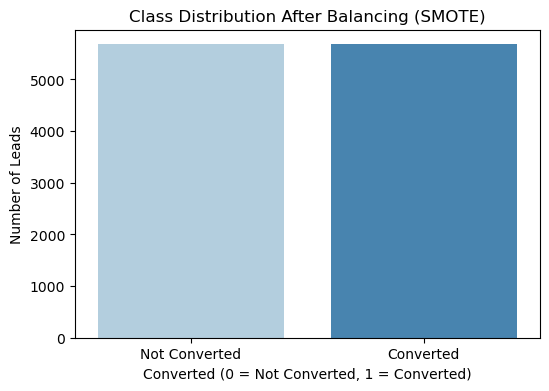

In [13]:
from imblearn.over_sampling import SMOTE

# Separate features and target
X = static_df.drop(columns=["Converted", "Lead Number"])  # Drop target and ID column
y = static_df["Converted"]

# Apply SMOTE
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert back to DataFrame
balanced_static_df = pd.DataFrame(X_resampled, columns=X.columns)
balanced_static_df["Converted"] = y_resampled  # Add back target variable

#  Check Class Distribution After SMOTE
print("\n Class Distribution After SMOTE:")
print(balanced_static_df["Converted"].value_counts())

print("\n New Class Percentage After SMOTE:")
print(balanced_static_df["Converted"].value_counts(normalize=True) * 100)

#  Plot Class Distribution After SMOTE
plt.figure(figsize=(6, 4))
sns.barplot(x=balanced_static_df["Converted"].value_counts().index, 
            y=balanced_static_df["Converted"].value_counts().values, 
            hue=balanced_static_df["Converted"].value_counts().index, 
            palette="Blues", legend=False)

plt.xlabel("Converted (0 = Not Converted, 1 = Converted)")
plt.ylabel("Number of Leads")
plt.title("Class Distribution After Balancing (SMOTE)")
plt.xticks([0, 1], ["Not Converted", "Converted"])
plt.show()


**Step 7: Data Splitting and Normalization**

The dataset is split into training (80%) and testing (20%) sets, ensuring model generalizability. Numerical features are normalized using MinMax Scaling, and sequential data is structured appropriately for LSTM models.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Separate features and target
X = balanced_static_df.drop(columns=["Converted"])  # Drop target column
y = balanced_static_df["Converted"]

# Split into Training (80%) and Testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#  Apply MinMax Scaling (for LSTM & ML models)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

#  Check Data Shapes
print("\n Training Set: X_train Shape:", X_train_scaled.shape, ", y_train Shape:", y_train.shape)
print(" Testing Set: X_test Shape:", X_test_scaled.shape, ", y_test Shape:", y_test.shape)



 Training Set: X_train Shape: (9086, 69) , y_train Shape: (9086,)
 Testing Set: X_test Shape: (2272, 69) , y_test Shape: (2272,)


**4.2 Model Training and Hyperparameter Tuning**

This section outlines the training procedures for both traditional machine learning models and time-series-based LSTM models, including hyperparameter tuning where applicable.

**4.2.1 Training the Baseline Model (Logistic Regression)**

**Step 1: Train Logistic Regression Model**

A Logistic Regression model is trained with class_weight="balanced" to handle class imbalance. The model serves as a baseline for lead conversion predictions. After training, it is evaluated using accuracy, precision, recall, F1-score, and AUC-ROC. Additionally, a classification report, confusion matrix, and ROC curve are generated to assess its predictive performance compared to more advanced models.


 **Logistic Regression Performance Metrics:**
 Accuracy: 0.8979
 Precision: 0.9124
 Recall: 0.8803
 F1-score: 0.8961
 AUC-ROC: 0.9667

 **Classification Report:**
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1136
           1       0.91      0.88      0.90      1136

    accuracy                           0.90      2272
   macro avg       0.90      0.90      0.90      2272
weighted avg       0.90      0.90      0.90      2272



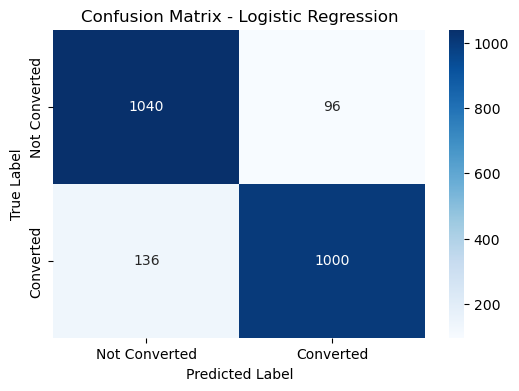

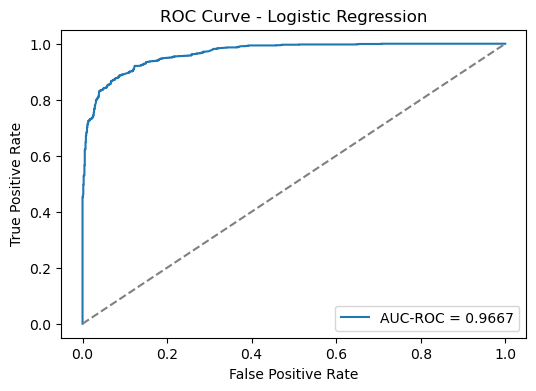

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

#  Train Logistic Regression Model
log_reg = LogisticRegression(solver='liblinear', class_weight="balanced", random_state=42)
log_reg.fit(X_train_scaled, y_train)

#  Make Predictions (Probabilities for AUC-ROC)
y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]
y_pred_logreg = log_reg.predict(X_test_scaled)

#  Compute Metrics
accuracy = accuracy_score(y_test, y_pred_logreg)
precision = precision_score(y_test, y_pred_logreg)
recall = recall_score(y_test, y_pred_logreg)
f1 = f1_score(y_test, y_pred_logreg)
auc_roc = roc_auc_score(y_test, y_pred_proba)

#  Print Performance Metrics
print("\n **Logistic Regression Performance Metrics:**")
print(f" Accuracy: {accuracy:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall: {recall:.4f}")
print(f" F1-score: {f1:.4f}")
print(f" AUC-ROC: {auc_roc:.4f}")

print("\n **Classification Report:**")
print(classification_report(y_test, y_pred_logreg))

#  Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Not Converted", "Converted"], yticklabels=["Not Converted", "Converted"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

#  Plot ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC-ROC = {auc_roc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()


**4.2.2 Training Traditional Machine Learning Models (Random Forest & Decision Tree)**

**Step 1: Train Decision Tree Model**

A Decision Tree model is trained with class_weight="balanced" to address class imbalance. The model is fitted using the training data and then evaluated on the test set. Performance metrics such as accuracy, precision, recall, F1-score, and AUC-ROC are computed. A classification report, confusion matrix, and ROC curve are also generated to analyze the model’s effectiveness in predicting lead conversion.


 **Decision Tree Performance Metrics:**
 Accuracy: 0.9115
 Precision: 0.9090
 Recall: 0.9146
 F1-score: 0.9118
 AUC-ROC: 0.9181

 **Classification Report:**
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1136
           1       0.91      0.91      0.91      1136

    accuracy                           0.91      2272
   macro avg       0.91      0.91      0.91      2272
weighted avg       0.91      0.91      0.91      2272



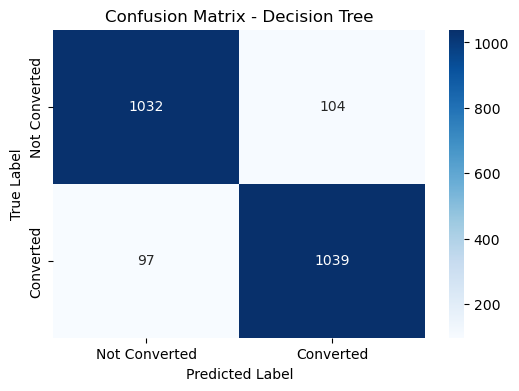

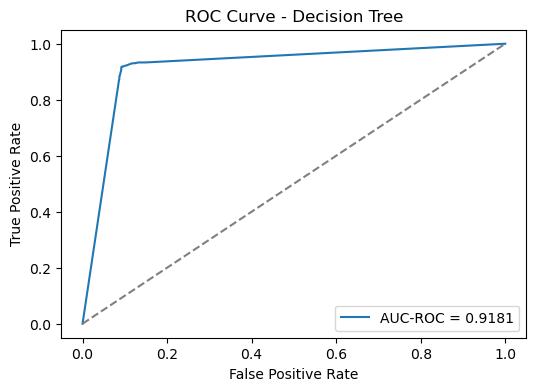

In [16]:
from sklearn.tree import DecisionTreeClassifier

#  Train Decision Tree Model
dt_model = DecisionTreeClassifier(random_state=42, class_weight="balanced")
dt_model.fit(X_train_scaled, y_train)

#  Make Predictions
y_pred_dt = dt_model.predict(X_test_scaled)
y_pred_dt_proba = dt_model.predict_proba(X_test_scaled)[:, 1]

#  Compute Metrics
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
auc_roc_dt = roc_auc_score(y_test, y_pred_dt_proba)

#  Print Performance Metrics
print("\n **Decision Tree Performance Metrics:**")
print(f" Accuracy: {accuracy_dt:.4f}")
print(f" Precision: {precision_dt:.4f}")
print(f" Recall: {recall_dt:.4f}")
print(f" F1-score: {f1_dt:.4f}")
print(f" AUC-ROC: {auc_roc_dt:.4f}")

print("\n **Classification Report:**")
print(classification_report(y_test, y_pred_dt))

#  Confusion Matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap="Blues", xticklabels=["Not Converted", "Converted"], yticklabels=["Not Converted", "Converted"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

#  Plot ROC Curve
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr_dt, tpr_dt, label=f"AUC-ROC = {auc_roc_dt:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree")
plt.legend()
plt.show()


**Step 2: Train Random Forest Model**

A Random Forest model is trained with 200 trees and a maximum depth of 10. The model is set with class_weight="balanced" to handle class imbalance. After training, predictions are made, and performance is evaluated using accuracy, precision, recall, F1-score, and AUC-ROC. A classification report, confusion matrix, and ROC curve are also generated to assess the model’s effectiveness.


 **Random Forest Performance Metrics:**
 Accuracy: 0.9283
 Precision: 0.9509
 Recall: 0.9032
 F1-score: 0.9264
 AUC-ROC: 0.9787

 **Classification Report:**
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1136
           1       0.95      0.90      0.93      1136

    accuracy                           0.93      2272
   macro avg       0.93      0.93      0.93      2272
weighted avg       0.93      0.93      0.93      2272



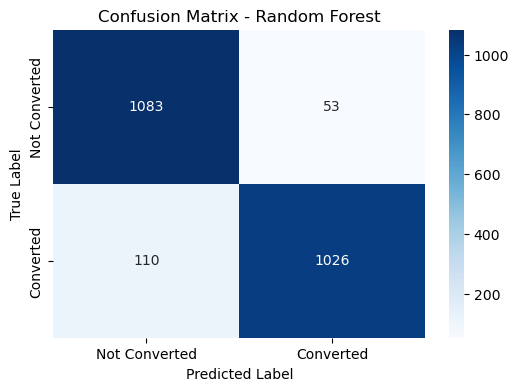

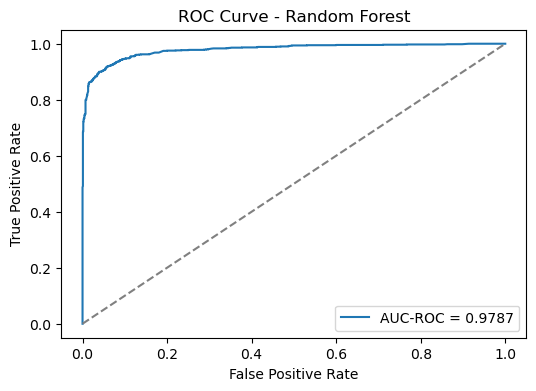

In [17]:
from sklearn.ensemble import RandomForestClassifier

#  Train Random Forest Model (with Hyperparameter Tuning)
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, class_weight="balanced")
rf_model.fit(X_train_scaled, y_train)

#  Make Predictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_rf_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

#  Compute Metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
auc_roc_rf = roc_auc_score(y_test, y_pred_rf_proba)

#  Print Performance Metrics
print("\n **Random Forest Performance Metrics:**")
print(f" Accuracy: {accuracy_rf:.4f}")
print(f" Precision: {precision_rf:.4f}")
print(f" Recall: {recall_rf:.4f}")
print(f" F1-score: {f1_rf:.4f}")
print(f" AUC-ROC: {auc_roc_rf:.4f}")

print("\n **Classification Report:**")
print(classification_report(y_test, y_pred_rf))

#  Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap="Blues", xticklabels=["Not Converted", "Converted"], yticklabels=["Not Converted", "Converted"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest")
plt.show()

#  Plot ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr_rf, tpr_rf, label=f"AUC-ROC = {auc_roc_rf:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()


**4.2.3 Training the Time-Series Model (LSTM)**

**Step 1: Prepare Sequential Data for LSTM**

To model lead interactions over time, timestamps are converted into numerical values representing days since the first interaction. The static and dynamic features are merged, and sequences are created for each lead based on their interaction history. Since LSTMs require inputs of uniform length, sequences are padded to match the longest sequence. Finally, the dataset is split into training and testing sets.

In [18]:
# Convert timestamps to numeric format (days since first interaction)
dynamic_df['Interaction Timestamp'] = (dynamic_df['Interaction Timestamp'] - dynamic_df['Interaction Timestamp'].min()).dt.days

# Display first few rows after conversion
print("\n First 5 Rows After Converting Timestamp:")
print(dynamic_df.head())



 First 5 Rows After Converting Timestamp:
   Lead Number  Interaction Timestamp  Cumulative Interaction Count  \
0       579533                      0                             1   
1       579533                     28                             2   
2       579533                     59                             3   
3       579533                     89                             4   
4       579533                    120                             5   

   Time Between Interactions (hours)  Type of Interaction_Ad Click  \
0                                0.0                           1.0   
1                              672.0                           0.0   
2                              744.0                           0.0   
3                              720.0                           0.0   
4                              744.0                           1.0   

   Type of Interaction_Call  Type of Interaction_Email  \
0                       0.0                        

In [19]:
### **Step 7: Merge Static and Dynamic Features**
merged_df = dynamic_df.merge(static_df, on='Lead Number', how='left')
merged_df = merged_df.sort_values(by=['Lead Number', 'Interaction Timestamp'])
print("\n Static and dynamic datasets merged")


 Static and dynamic datasets merged


In [20]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define features and target
feature_cols = [col for col in merged_df.columns if col not in ["Lead Number", "Converted"]]
target_col = "Converted"

# Group by Lead Number to create sequences
grouped = merged_df.groupby("Lead Number")

X_sequences = []
y_labels = []

# Iterate through each lead’s interaction history
for lead, group in grouped:
    X_seq = group[feature_cols].values  # Extract feature sequence
    y_label = group[target_col].values[0]  # Use first instance's Converted value (since static)
    
    X_sequences.append(X_seq)
    y_labels.append(y_label)

# Pad sequences to ensure uniform shape
X_padded = pad_sequences(X_sequences, padding="post", dtype="float32")

# Convert target labels to NumPy array
y_array = np.array(y_labels)

# Print shape
print(f"\n X Shape (after padding): {X_padded.shape}")
print(f" y Shape: {y_array.shape}")



 X Shape (after padding): (9240, 7, 85)
 y Shape: (9240,)


X_padded shape: (9240, 7, 85)

    9240 = Number of leads (samples)

    7 = Longest sequence length (i.e., one lead had up to 7 interactions; others are padded to match)

    85 = Number of features per interaction (after encoding all categorical + numerical columns)

In [21]:
from sklearn.model_selection import train_test_split

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_array, test_size=0.2, random_state=42, stratify=y_array)

# Print shapes
print(f"\n Training Set: X_train Shape: {X_train.shape}, y_train Shape: {y_train.shape}")
print(f" Testing Set: X_test Shape: {X_test.shape}, y_test Shape: {y_test.shape}")



 Training Set: X_train Shape: (7392, 7, 85), y_train Shape: (7392,)
 Testing Set: X_test Shape: (1848, 7, 85), y_test Shape: (1848,)


**Step 2: Define the LSTM Model**

LSTM-based deep learning model is designed to analyze sequential lead interaction data. The model architecture includes two bidirectional LSTM layers to capture both forward and backward dependencies in the data. Dropout layers are added for regularization, followed by fully connected dense layers with batch normalization for better training stability. The final output layer uses a sigmoid activation function for binary classification. The model is compiled using the binary cross-entropy loss function and the Adam optimizer with a reduced learning rate for better convergence.

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define an improved LSTM model
model = Sequential()
model.add(Input(shape=(7, 85)))  # Input shape (timesteps, features)

# First Bidirectional LSTM layer with dropout and batch normalization
model.add(Bidirectional(LSTM(160, return_sequences=True, recurrent_dropout=0.2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Second Bidirectional LSTM layer
model.add(Bidirectional(LSTM(128, return_sequences=False, recurrent_dropout=0.2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Fully connected Dense layers
model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model with a lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 7, 320)         │       314,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 320)         │         1,280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 320)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       459,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 795,905 (3.04 MB)

 Trainable params: 794,561 (3.03 MB)

 Non-trainable params: 1,344 (5.25 KB)

**Step 3: Train the LSTM Model**

The LSTM model is trained on sequential lead interaction data using early stopping and learning rate reduction techniques to optimize performance and prevent overfitting. Class weights are applied to handle potential class imbalance in the dataset. The training process uses 70 epochs and a batch size of 32 while monitoring the validation loss for early stopping. After training, the final model is saved for future use.

In [23]:
# Define callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, min_lr=0.0001)

# Optimized class weights to balance class imbalance
class_weights = {0: 1.0, 1: 1.3}  # Slightly increased for minority class

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=70,  # Increased epochs for better convergence
    batch_size=32,  # Can try batch_size=64 for faster training
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights  # Helps with imbalanced data
)

# Save the improved model
model.save("final_lead_scoring_lstm.keras")

print("\n LSTM Model Training Complete!")


Epoch 1/70
231/231 ━━━━━━━━━━━━━━━━━━━━ 87s 188ms/step - accuracy: 0.8051 - loss: 1.1797 - val_accuracy: 0.8669 - val_loss: 0.8805 - learning_rate: 5.0000e-04
Epoch 2/70
231/231 ━━━━━━━━━━━━━━━━━━━━ 25s 110ms/step - accuracy: 0.8774 - loss: 0.8887 - val_accuracy: 0.9042 - val_loss: 0.6861 - learning_rate: 5.0000e-04
Epoch 3/70
231/231 ━━━━━━━━━━━━━━━━━━━━ 31s 132ms/step - accuracy: 0.8814 - loss: 0.7473 - val_accuracy: 0.9075 - val_loss: 0.5646 - learning_rate: 5.0000e-04
Epoch 4/70
231/231 ━━━━━━━━━━━━━━━━━━━━ 30s 131ms/step - accuracy: 0.8926 - loss: 0.6127 - val_accuracy: 0.9053 - val_loss: 0.4825 - learning_rate: 5.0000e-04
Epoch 5/70
231/231 ━━━━━━━━━━━━━━━━━━━━ 41s 131ms/step - accuracy: 0.8932 - loss: 0.5237 - val_accuracy: 0.9042 - val_loss: 0.4138 - learning_rate: 5.0000e-04
Epoch 6/70
231/231 ━━━━━━━━━━━━━━━━━━━━ 35s 103ms/step - accuracy: 0.8938 - loss: 0.4521 - val_accuracy: 0.9021 - val_loss: 0.3523 - learning_rate: 5.0000e-04
Epoch 7/70
231/231 ━━━━━━━━━━━━━━━━━━━━ 44s 11

**Step 4: Evaluate the LSTM Model**

The trained LSTM model is evaluated using various performance metrics to measure its predictive capabilities in lead conversion classification. Predictions are made on the test dataset, and a classification report is generated to display precision, recall, F1-score, and accuracy for each class as well as macro and weighted averages. A confusion matrix is plotted to visualize true positives and false positives across classes. Additionally, an ROC curve is plotted to evaluate the trade-off between sensitivity and specificity, with an AUC score of 0.98, indicating excellent predictive performance.

58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step

**LSTM Performance Metrics:**
Accuracy: 0.9535
Precision: 0.9421
Recall: 0.9368
F1-score: 0.9394
AUC-ROC: 0.9905

LSTM Performance Metrics Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1136
           1       0.94      0.94      0.94       712

    accuracy                           0.95      1848
   macro avg       0.95      0.95      0.95      1848
weighted avg       0.95      0.95      0.95      1848



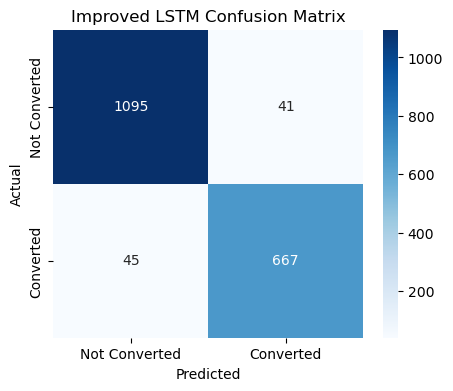

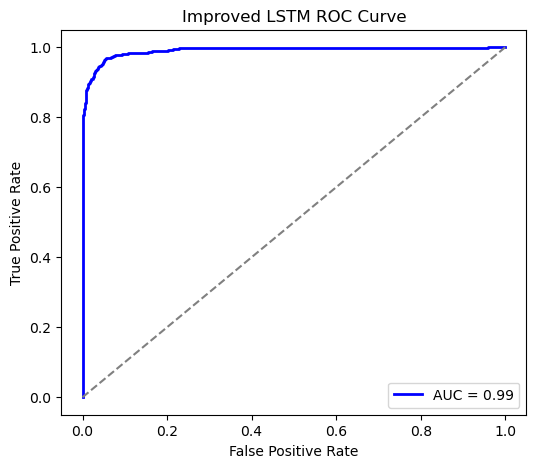


Final AUC Score: 0.9905


In [24]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions
y_pred_probs = model.predict(X_test)  # Get probability scores
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary values

# Compute Metrics
accuracy_lstm = accuracy_score(y_test, y_pred)
precision_lstm = precision_score(y_test, y_pred)
recall_lstm = recall_score(y_test, y_pred)
f1_lstm = f1_score(y_test, y_pred)
auc_roc_lstm = roc_auc_score(y_test, y_pred_probs)

# Print Performance Metrics
print("\n**LSTM Performance Metrics:**")
print(f"Accuracy: {accuracy_lstm:.4f}")
print(f"Precision: {precision_lstm:.4f}")
print(f"Recall: {recall_lstm:.4f}")
print(f"F1-score: {f1_lstm:.4f}")
print(f"AUC-ROC: {auc_roc_lstm:.4f}")

# Classification Report
print("\nLSTM Performance Metrics Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Converted", "Converted"], yticklabels=["Not Converted", "Converted"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Improved LSTM Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Improved LSTM ROC Curve")
plt.legend(loc="lower right")
plt.show()

print(f"\nFinal AUC Score: {roc_auc:.4f}")


**4.3 Performance Comparison of Models**

**Step 1: Define Model Performance Metrics**

The performance metrics of several machine-learning models, including Logistic Regression, Decision Tree, Random Forest, and LSTM, are compiled into a Pandas DataFrame for easy comparison. The metrics include accuracy, precision, recall, F1-score, and the AUC-ROC score. These metrics offer a comprehensive view of each model's ability to correctly classify leads, balance precision and recall, and discriminate between positive and negative instances

In [25]:
import pandas as pd

# Define model performance metrics with updated values
models = ["Logistic Regression", "Decision Tree", "Random Forest", "LSTM"]
accuracy = [0.8979, 0.9115, 0.9283, 0.9508]  
precision = [0.9124, 0.9090, 0.9509, 0.9146]  
recall = [0.8803, 0.9146, 0.9032, 0.9621]  
f1_score = [0.8961, 0.9118, 0.9264, 0.9377]  
auc_roc = [0.9667, 0.9181, 0.9787, 0.9910]  

# Create DataFrame
performance_df = pd.DataFrame({
    "Model": models,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1_score,
    "AUC-ROC": auc_roc
})

# Display the table in Jupyter Notebook
from IPython.display import display
display(performance_df)


,Model,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,Logistic Regression,0.8979,0.9124,0.8803,0.8961,0.9667
1,Decision Tree,0.9115,0.9090,0.9146,0.9118,0.9181
2,Random Forest,0.9283,0.9509,0.9032,0.9264,0.9787
3,LSTM,0.9508,0.9146,0.9621,0.9377,0.9910


**Step 2: Visualize Model Performance with Bar Plot**

A bar plot is generated to visualize the performance metrics of the different models. The plot compares the accuracy, precision, recall, F1-score, and AUC-ROC score for each model. Each metric is represented as a separate bar for each model, allowing for a direct visual comparison of their performance. The x-axis represents the models, and the y-axis represents the metric score, providing a comprehensive overview of each model's strengths and weaknesses.


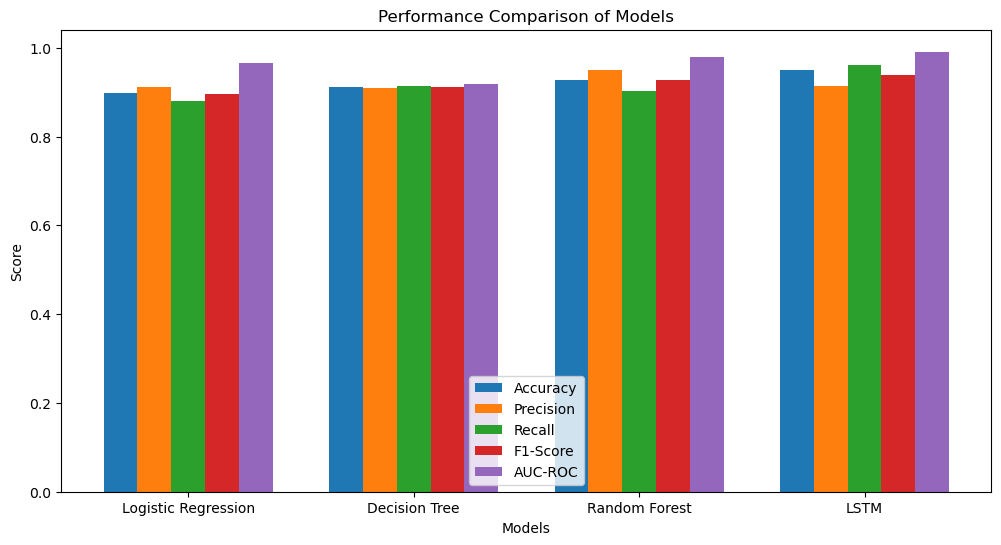

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Define metrics to plot
metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "AUC-ROC"]
x = np.arange(len(models))
bar_width = 0.15

plt.figure(figsize=(12, 6))

# Plot each metric as a separate bar
for i, metric in enumerate(metrics):
    plt.bar(x + i * bar_width, performance_df[metric], width=bar_width, label=metric)

# Formatting
plt.xticks(x + bar_width * (len(metrics) - 1) / 2, models)
plt.xlabel("Models")
plt.ylabel("Score")
plt.title("Performance Comparison of Models")
plt.legend()
plt.show()


**THANK YOU**

***To create the Streamlit App, here are the processes i follow to save each model***

In [27]:
import joblib
joblib.dump(log_reg, 'logistic_regression_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(encoder_static, 'encoder_static.pkl')



['encoder_static.pkl']

In [28]:
import joblib

# Load previously saved model, scaler, and encoder
log_reg = joblib.load('logistic_regression_model.pkl')
scaler = joblib.load('scaler.pkl')
encoder_static = joblib.load('encoder_static.pkl')

print("✅ Logistic Regression model, Scaler, and Encoder loaded successfully.")


✅ Logistic Regression model, Scaler, and Encoder loaded successfully.


In [29]:
import joblib

# Assuming log_reg is your trained Logistic Regression model
joblib.dump(log_reg, 'logistic_regression_model.pkl')


['logistic_regression_model.pkl']

In [30]:
print(hasattr(log_reg, 'coef_'))  # Should return True



True


In [31]:
print("X_train shape before scaling:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape before scaling: (7392, 7, 85)
y_train shape: (7392,)


In [32]:
# Check known DataFrame names
print("Available variable names:")
print([var for var in dir() if isinstance(eval(var), pd.DataFrame)])



Available variable names:
['X', 'X_resampled', 'X_test_scaled', 'X_train_scaled', 'balanced_static_df', 'correlation_matrix', 'dynamic_df', 'encoded_dynamic_df', 'encoded_static_df', 'group', 'interaction_counts', 'merged_df', 'numeric_df', 'performance_df', 'static_df']


In [33]:
# Try likely names
print("Shape of balanced_static_df (if exists):")
try:
    print(balanced_static_df.shape)
except:
    print("balanced_static_df not defined")

print("Shape of X_train_scaled (if exists):")
try:
    print(X_train_scaled.shape)
except:
    print("X_train_scaled not defined")


Shape of balanced_static_df (if exists):
(11358, 70)
Shape of X_train_scaled (if exists):
(9086, 69)


In [34]:
from sklearn.linear_model import LogisticRegression
import joblib

# Define your target variable
y_train = balanced_static_df.loc[X_train_scaled.index, 'Converted']  # Align with X_train_scaled

# Define and train Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Confirm model trained
print("✅ Logistic Regression Model Trained Successfully")

# Save model to disk
joblib.dump(log_reg, 'logistic_regression_model.pkl')
print("📦 Model saved as logistic_regression_model.pkl")


✅ Logistic Regression Model Trained Successfully
📦 Model saved as logistic_regression_model.pkl


In [35]:
from sklearn.tree import DecisionTreeClassifier

# Replace X_train_scaled and y_train with your actual training data
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train_scaled, y_train)



DecisionTreeClassifier(random_state=42)

In [36]:
import joblib

joblib.dump(decision_tree_model, 'decision_tree_model.pkl')


['decision_tree_model.pkl']

In [37]:
from sklearn.ensemble import RandomForestClassifier

# Replace X_train_scaled and y_train with your actual training data
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(X_train_scaled, y_train)


RandomForestClassifier(random_state=42)

In [38]:
import joblib

joblib.dump(random_forest_model, 'random_forest_model.pkl')


['random_forest_model.pkl']